Check Python version

In [1]:
!python --version

Python 3.9.18


Import libraries

In [2]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [3]:
file_name = 'temp_anom_w_forcing.csv'

In [4]:
dataset = pd.read_csv(file_name)

In [5]:
dataset.shape

(163, 11)

In [6]:
dataset.columns

Index(['Year', 'WMGHG', 'Ozone', 'Solar', 'Land_Use', 'SnowAlb_BC', 'Orbital',
       'TropAerDir', 'TropAerInd', 'StratAer', 'Anomaly'],
      dtype='object')

In [7]:
dataset.head()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly
0,1850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.17
1,1851,0.005954,0.000745,0.001166,-0.000940,0.000649,0.000653,0.000649,-0.000005,0.029088,-0.09
2,1852,0.010502,0.000909,-0.010756,-0.002531,0.000649,0.000671,0.000649,-0.000005,0.056712,-0.11
3,1853,0.014587,0.001020,-0.027220,-0.004123,0.000649,0.000688,0.000649,-0.000005,0.077260,-0.12
4,1854,0.020521,0.001188,-0.045539,-0.005717,0.000649,0.000689,0.000649,-0.000005,0.085759,-0.12


In [8]:
dataset.tail()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly
158,2008,3.36688,0.451834,-0.009377,-0.205278,0.053937,0.002234,-0.189395,-0.697385,0.059742,0.55
159,2009,3.40963,0.451834,-0.006203,-0.205278,0.053937,0.002241,-0.189395,-0.697385,0.040626,0.66
160,2010,3.45082,0.451834,0.020822,-0.205278,0.053937,0.002254,-0.189395,-0.697385,0.081508,0.73
161,2011,3.49278,0.451834,0.058369,-0.205278,0.053937,0.002261,-0.189395,-0.697385,0.088224,0.62
162,2012,3.53407,0.451834,0.095752,-0.205278,0.053937,0.002277,-0.189395,-0.697385,0.088224,0.66


Define the required time and target columns

In [9]:
time_col = dataset.columns[0]
target_col = dataset.columns[-1]
dataset[time_col] = dataset[time_col].astype(str)

Change target column to float

In [10]:
# dataset[target_col] = dataset[target_col].astype(float)

In [11]:
# dataset.head()

Split dataset into train and test sets

In [12]:
train_size = 0.8
train_points = int(train_size*len(dataset))
train_df = dataset.iloc[:train_points]
test_df = dataset.iloc[train_points:]

Plot graph

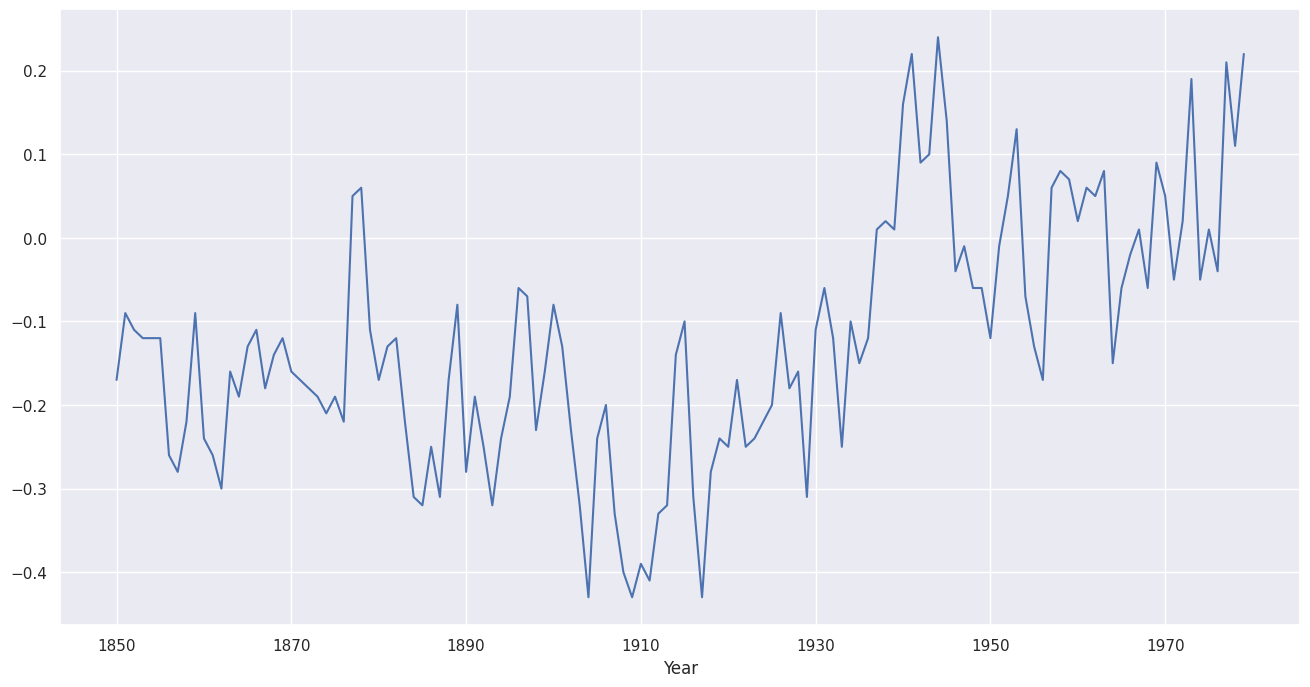

In [13]:
figsize = (16, 8)
train_df.set_index(time_col)[target_col].plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [14]:
train_data = []
for value in train_df.values:
    train_data.append(list(value))

In [15]:
train_data[:2]

[['1850', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.17],
 ['1851',
  0.00595381,
  0.0007451,
  0.00116604,
  -0.0009399,
  0.00064918,
  0.00065287,
  0.00064918,
  -4.97297e-06,
  0.0290878,
  -0.09]]

Custom Model Request (optional)

In [16]:
# Default model request
model_request = {
    'type': 'neuralprophet',  # 'meta_wa'
    # 'metrics': ['smape', 'mape'],
    'metrics': ['rmse', 'mae'],
    'params': {
        'lagged_regressors': [
            { 'index': 0 },
            { 'index': 1 },
            { 'index': 2 },
            { 'index': 3 },
            { 'index': 4 },
            { 'index': 5 },
            { 'index': 6 },
            { 'index': 7 },
            { 'index': 8 }
        ],
        "epochs": 5
    },
}

Train API JSON Payload

In [17]:
api_json = {
    'data': train_data,
    'model': model_request  # (optional) can be commented out
}

Build URL

In [18]:
with open('np_url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [19]:
# URL to our SYBIL AWS service
protocol = url_dict['protocol']
host = url_dict['host']
port = url_dict['port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [20]:
# protocol, host, port

Call endpoint, receive response JSON, write to output file

In [21]:
%%time
response = requests.post(url, json=api_json, verify=False)
print(response)
print()

/home/studio-lab-user/.conda/envs/obnp/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'neuralprophet.tempor.ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<Response [200]>

CPU times: user 18.5 ms, sys: 4.18 ms, total: 22.7 ms
Wall time: 910 ms


In [22]:
train_json_out = response.json()  # dict output
train_json_out

{'status': 'ok',
 'metrics': {},
 'model': 'UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY25ldXJhbHByb3BoZXQuZm9yZWNhc3RlcgpOZXVyYWxQcm9waGV0CnEAKYFxAX1xAihYBgAAAGNvbmZpZ3EDfXEEKFgGAAAAZ3Jvd3RocQVYBgAAAGxpbmVhcnEGWAwAAABjaGFuZ2Vwb2ludHNxB05YDgAAAG5fY2hhbmdlcG9pbnRzcQhLClgSAAAAY2hhbmdlcG9pbnRzX3JhbmdlcQlHP+mZmZmZmZpYCQAAAHRyZW5kX3JlZ3EKSwBYEwAAAHRyZW5kX3JlZ190aHJlc2hvbGRxC4lYEgAAAHRyZW5kX2dsb2JhbF9sb2NhbHEMWAYAAABnbG9iYWxxDVgSAAAAeWVhcmx5X3NlYXNvbmFsaXR5cQ5YBAAAAGF1dG9xD1gSAAAAd2Vla2x5X3NlYXNvbmFsaXR5cRBoD1gRAAAAZGFpbHlfc2Vhc29uYWxpdHlxEWgPWBAAAABzZWFzb25hbGl0eV9tb2RlcRJYCAAAAGFkZGl0aXZlcRNYDwAAAHNlYXNvbmFsaXR5X3JlZ3EUSwBYEwAAAHNlYXNvbl9nbG9iYWxfbG9jYWxxFWgNWAsAAABuX2ZvcmVjYXN0c3EWSwFYBgAAAG5fbGFnc3EXSwBYCQAAAGFyX2xheWVyc3EYXXEZWAYAAABhcl9yZWdxGk5YEQAAAGxhZ2dlZF9yZWdfbGF5ZXJzcRtdcRxYDQAAAGxlYXJuaW5nX3JhdGVxHU5YBgAAAGVwb2Noc3EeSwVYCgAAAGJhdGNoX3NpemVxH05YCQAAAGxvc3NfZnVuY3EgWAUAAABIdWJlcnEhWAkAAABvcHRpbWl6ZXJxIlgFAAAAQWRhbVdxI1gUAAAAbmV3ZXJfc2Ft

### **Forecast API**

Forecast Dates: predict the next 32 years of temperature anomaly data (1980-2012)

In [23]:
test_data = []
for value in test_df.drop(columns=target_col).values:
    test_data.append(list(value))

In [24]:
test_data[:2]

[['1980',
  2.09837,
  0.362496,
  0.132923,
  -0.197799,
  0.0534377,
  0.00195668,
  -0.116014,
  -0.557516,
  -0.0294989],
 ['1981',
  2.15487,
  0.37198,
  0.13994,
  -0.198391,
  0.0534899,
  0.00196222,
  -0.12073,
  -0.572096,
  -0.0378411]]

Model from Train API

In [25]:
model = train_json_out['model']

Forecast API JSON Payload

In [26]:
api_json = {
    'model': model,
    'data': test_data
}

Build URL (same as train except for the endpoint)

In [27]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [28]:
%%time
response = requests.post(url, json=api_json, verify=False)
print(response)
print()

/home/studio-lab-user/.conda/envs/obnp/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'neuralprophet.tempor.ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<Response [200]>

CPU times: user 17.8 ms, sys: 2.94 ms, total: 20.8 ms
Wall time: 371 ms


In [29]:
forecast_json_out = response.json()  # dict output
forecast_json_out

{'status': 'ok',
 'forecast': {'ds': {'1': '1981-01-01T00:00:00',
   '2': '1982-01-01T00:00:00',
   '3': '1983-01-01T00:00:00',
   '4': '1984-01-01T00:00:00',
   '5': '1985-01-01T00:00:00',
   '6': '1986-01-01T00:00:00',
   '7': '1987-01-01T00:00:00',
   '8': '1988-01-01T00:00:00',
   '9': '1989-01-01T00:00:00',
   '10': '1990-01-01T00:00:00',
   '11': '1991-01-01T00:00:00',
   '12': '1992-01-01T00:00:00',
   '13': '1993-01-01T00:00:00',
   '14': '1994-01-01T00:00:00',
   '15': '1995-01-01T00:00:00',
   '16': '1996-01-01T00:00:00',
   '17': '1997-01-01T00:00:00',
   '18': '1998-01-01T00:00:00',
   '19': '1999-01-01T00:00:00',
   '20': '2000-01-01T00:00:00',
   '21': '2001-01-01T00:00:00',
   '22': '2002-01-01T00:00:00',
   '23': '2003-01-01T00:00:00',
   '24': '2004-01-01T00:00:00',
   '25': '2005-01-01T00:00:00',
   '26': '2006-01-01T00:00:00',
   '27': '2007-01-01T00:00:00',
   '28': '2008-01-01T00:00:00',
   '29': '2009-01-01T00:00:00',
   '30': '2010-01-01T00:00:00',
   '31': '2011

Combine forecast dates and output

In [30]:
forecast = forecast_json_out['forecast']

# forecast_ds = list(forecast['ds'].values())
# forecast_yhat = list(forecast['yhat1'].values())
forecast_ds = forecast['ds'].values()
forecast_yhat = forecast['yhat1'].values()

forecast_df = pd.DataFrame.from_dict(
    data={
        time_col: forecast_ds,
        target_col: forecast_yhat,
    },
    # columns=[time_col, target_col],
)

In [31]:
forecast_df.shape

(32, 2)

In [32]:
forecast_df.columns

Index(['Year', 'Anomaly'], dtype='object')

In [33]:
forecast_df.head()

,Year,Anomaly
0,1981-01-01T00:00:00,-13.111813
1,1982-01-01T00:00:00,-12.971117
2,1983-01-01T00:00:00,-12.878697
3,1984-01-01T00:00:00,-12.762413
4,1985-01-01T00:00:00,-12.243032


In [34]:
forecast_df.tail()

,Year,Anomaly
27,2008-01-01T00:00:00,-9.598673
28,2009-01-01T00:00:00,-9.518619
29,2010-01-01T00:00:00,-9.419650
30,2011-01-01T00:00:00,-9.384565
31,2012-01-01T00:00:00,-9.384476


Plot train and forecast side-by-side

/tmp/ipykernel_1468/2998340865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['color'] = 'b'


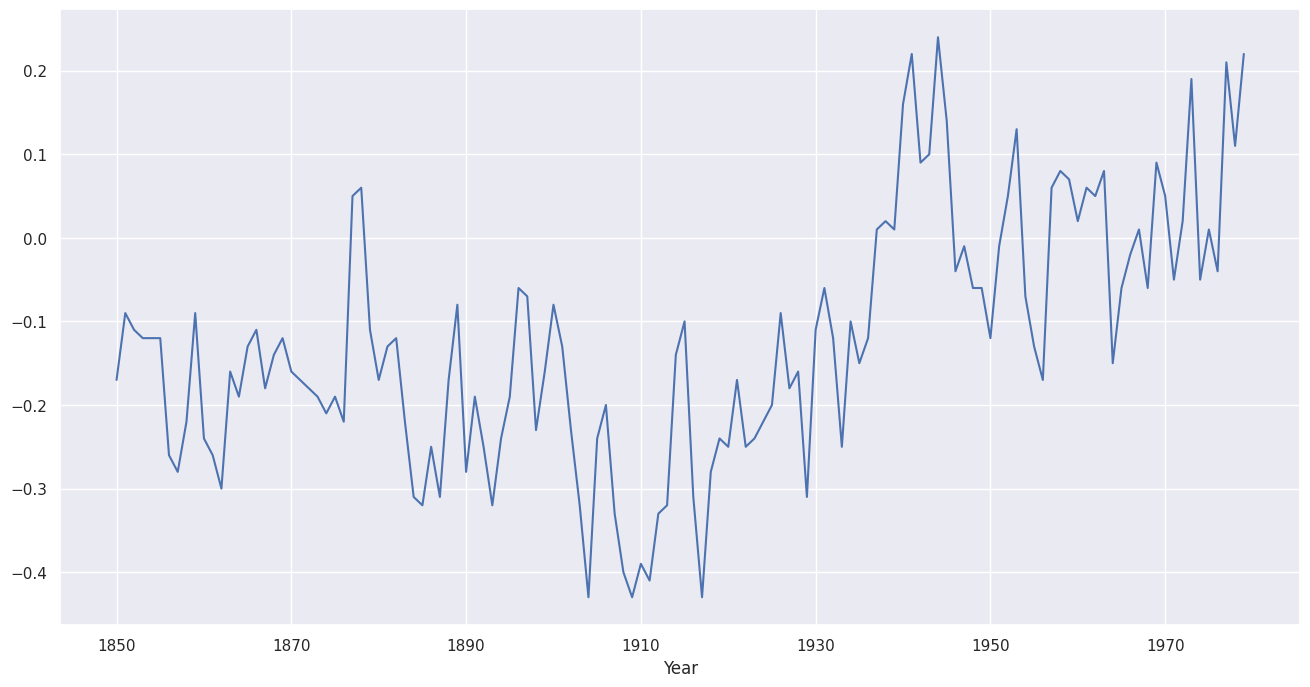

In [35]:
train_df['color'] = 'b'
train_df.set_index(time_col)[target_col].plot(figsize=figsize, color=train_df['color']);

In [36]:
forecast_df

,Year,Anomaly
0,1981-01-01T00:00:00,-13.111813
1,1982-01-01T00:00:00,-12.971117
2,1983-01-01T00:00:00,-12.878697
3,1984-01-01T00:00:00,-12.762413
4,1985-01-01T00:00:00,-12.243032
5,1986-01-01T00:00:00,-11.944871
6,1987-01-01T00:00:00,-11.799569
7,1988-01-01T00:00:00,-11.658588
8,1989-01-01T00:00:00,-11.620291
9,1990-01-01T00:00:00,-11.723609


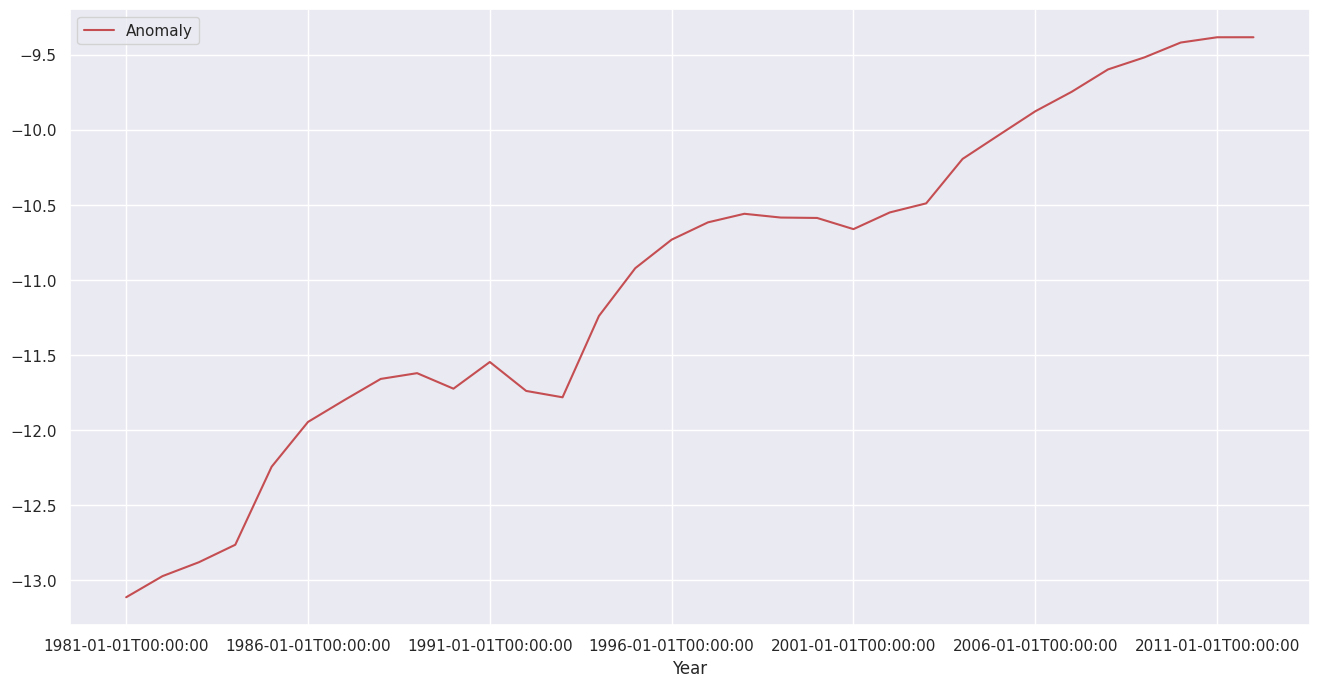

In [37]:
forecast_df['color'] = 'r'
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df['color']);

Combine train and test sets

In [38]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [39]:
df.shape

(162, 12)

In [40]:
df.head()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly,color
0,1850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.17,b
1,1851,0.005954,0.000745,0.001166,-0.000940,0.000649,0.000653,0.000649,-0.000005,0.029088,-0.09,b
2,1852,0.010502,0.000909,-0.010756,-0.002531,0.000649,0.000671,0.000649,-0.000005,0.056712,-0.11,b
3,1853,0.014587,0.001020,-0.027220,-0.004123,0.000649,0.000688,0.000649,-0.000005,0.077260,-0.12,b
4,1854,0.020521,0.001188,-0.045539,-0.005717,0.000649,0.000689,0.000649,-0.000005,0.085759,-0.12,b


In [41]:
df.tail()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly,color
157,2008-01-01T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.598673,r
158,2009-01-01T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.518619,r
159,2010-01-01T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.419650,r
160,2011-01-01T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.384565,r
161,2012-01-01T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.384476,r


Plot combined train and test sets with the vertical black line as the cut-off

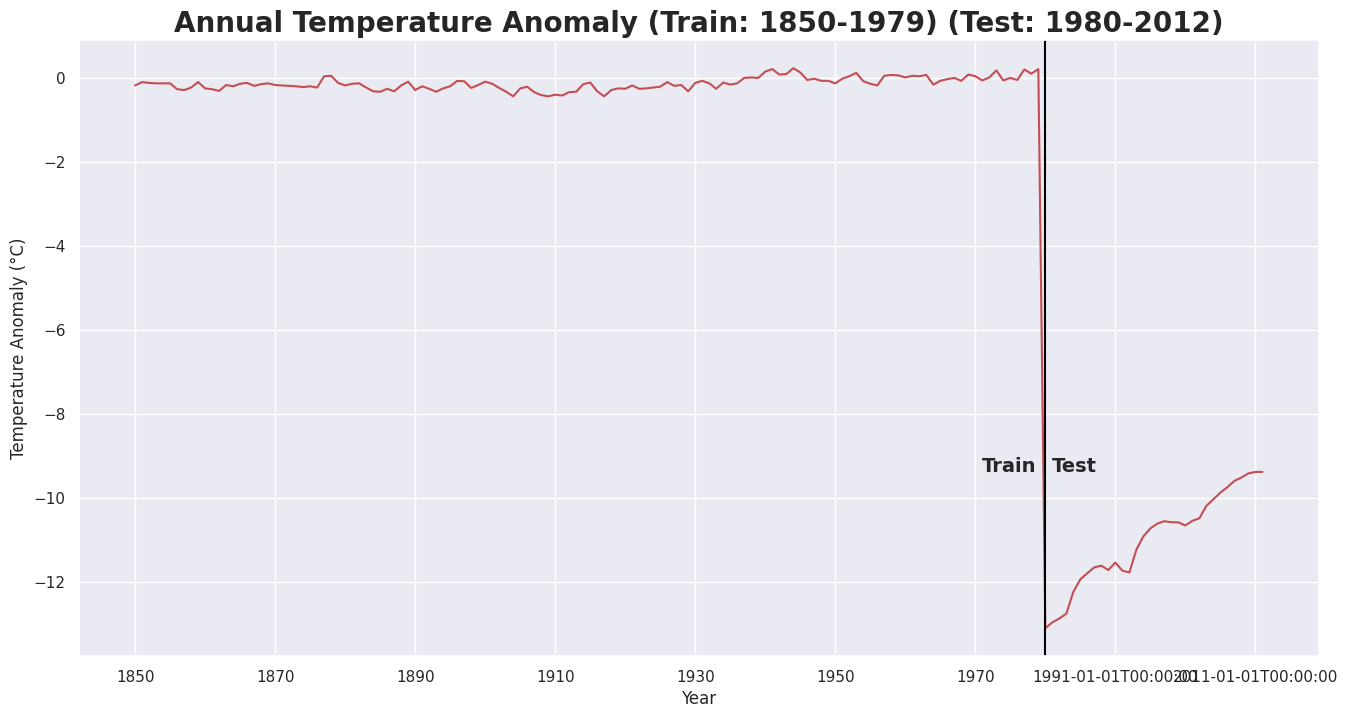

In [42]:
df.set_index(time_col)[target_col].plot(figsize=figsize, color='r')
plt.axvline(x=len(train_df), color='black', label='Train/Test set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Test', fontweight='bold', fontsize=14)
plt.ylabel(ylabel='Temperature Anomaly (' + u'\N{DEGREE SIGN}' + 'C)')
plt.title(label='Annual Temperature Anomaly (Train: 1850-1979) (Test: 1980-2012)', fontweight='bold', fontsize=20)
plt.show();

Plot original dataset to compare

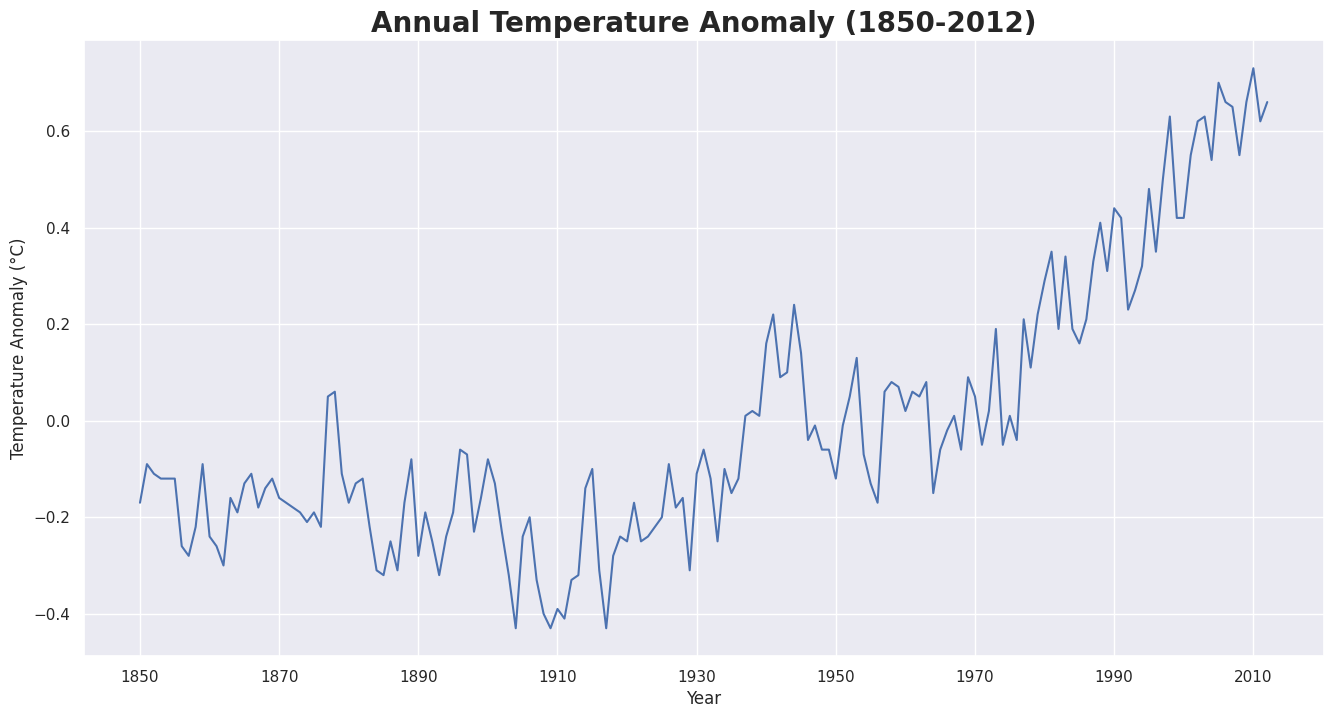

In [43]:
figsize = (16, 8)
dataset.set_index(time_col)[target_col].plot(figsize=figsize);
plt.ylabel(ylabel='Temperature Anomaly (' + u'\N{DEGREE SIGN}' + 'C)')
plt.title(label='Annual Temperature Anomaly (1850-2012)', fontweight='bold', fontsize=20)
plt.show();

Plot original dataset (blue) with SYBIL forecasted values (red)

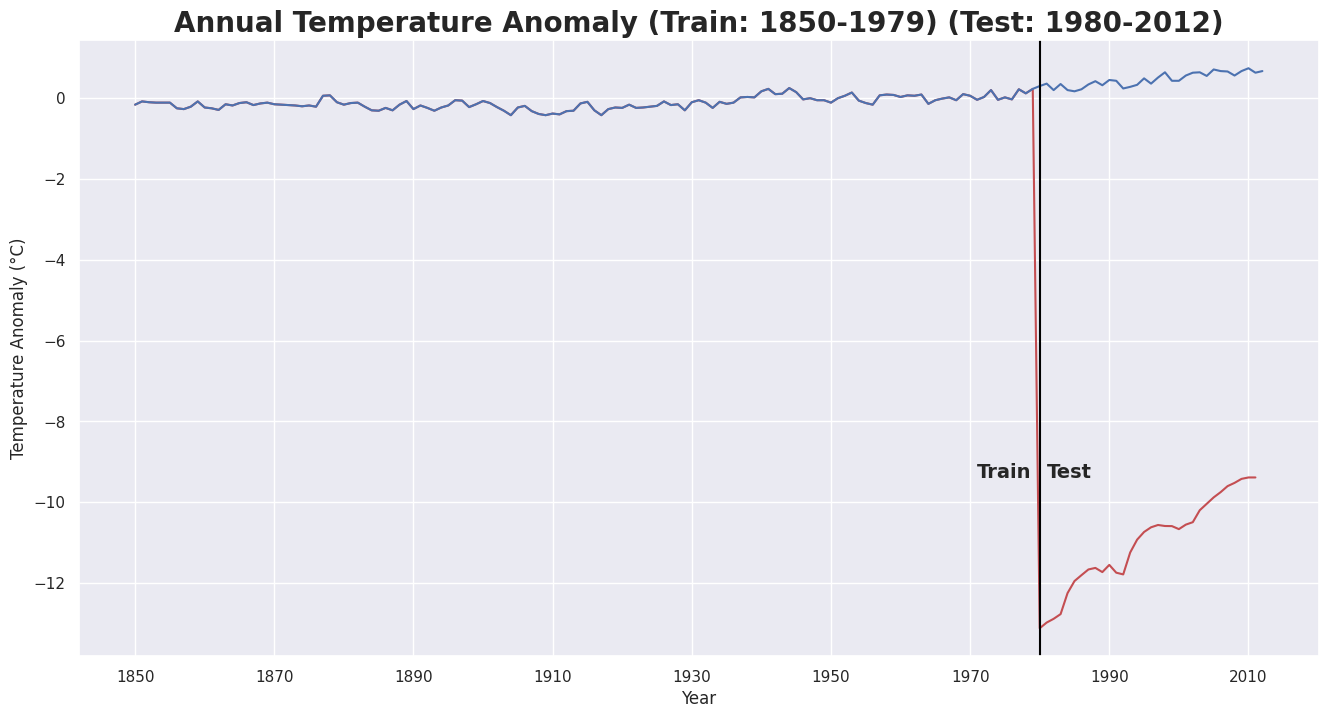

In [44]:
df.set_index(time_col)[target_col].plot(figsize=figsize, color='r')
dataset.set_index(time_col)[target_col].plot(figsize=figsize);
plt.axvline(x=len(train_df), color='black', label='Train/Test set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Test', fontweight='bold', fontsize=14)
plt.ylabel(ylabel='Temperature Anomaly (' + u'\N{DEGREE SIGN}' + 'C)')
plt.title(label='Annual Temperature Anomaly (Train: 1850-1979) (Test: 1980-2012)', fontweight='bold', fontsize=20)
plt.show();